In [1]:
cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [43]:
from joblib import load
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DEFAULT_QUERY_RESULT_DIR = Path("results/query_results")


In [4]:
def load_query_result(yadl_version, index_name, tab_name, query_column, top_k):
    query_result_path = "{}__{}__{}__{}.pickle".format(
        yadl_version,
        index_name,
        tab_name,
        query_column,
    )

    with open(
        Path(DEFAULT_QUERY_RESULT_DIR, query_result_path), "rb"
    ) as fp:
        query_result = pickle.load(fp)

    query_result.select_top_k(top_k)
    return query_result


In [5]:
yadl_version = "wordnet_full"
index_names = ["exact_matching", "minhash", "minhash_hybrid"]
tabs = [
    "company_employees", 
    "housing_prices",
    "movies_vote",
    "movies",
    "us_accidents",
    "us_county_population",
    "us_elections"
]
query_column = "col_to_embed"
top_k=0

In [6]:
for iname in index_names:
    for tab in tabs:
        tab_name = f"{tab}-yadl-depleted"
        query_result = load_query_result(yadl_version, iname, tab_name, query_column, top_k)
        print(iname, tab, query_result.n_candidates)

exact_matching company_employees 200
exact_matching housing_prices 200
exact_matching movies_vote 200
exact_matching movies 200
exact_matching us_accidents 200
exact_matching us_county_population 200
exact_matching us_elections 200
minhash company_employees 2292
minhash housing_prices 4113
minhash movies_vote 791
minhash movies 791
minhash us_accidents 5012
minhash us_county_population 4247
minhash us_elections 4247
minhash_hybrid company_employees 2292
minhash_hybrid housing_prices 4113
minhash_hybrid movies_vote 791
minhash_hybrid movies 791
minhash_hybrid us_accidents 5012
minhash_hybrid us_county_population 4247
minhash_hybrid us_elections 4247


In [7]:
c=query_result.candidates.popitem()

In [8]:
vars(c[1])

{'indexing_method': 'minhash',
 'source_table': 'c2a75df3db370e96cc7d9598e36272f4',
 'candidate_table': '31678a49a35ab6c17e6ef4df5d53e394',
 'source_metadata': {'full_path': '/home/soda/rcappuzz/work/benchmark-join-suggestions/data/source_tables/yadl/us_elections-yadl-depleted.parquet',
  'hash': 'c2a75df3db370e96cc7d9598e36272f4',
  'df_name': 'us_elections-yadl-depleted',
  'source_dl': 'queries',
  'license': '',
  'path_metadata': '/storage/store3/soda/rcappuzz/bench/data/metadata/queries/c2a75df3db370e96cc7d9598e36272f4.json'},
 'candidate_metadata': {'full_path': 'data/yadl/wordnet_full/wordnet_full-wordnet_soldier_110622053.parquet',
  'hash': '31678a49a35ab6c17e6ef4df5d53e394',
  'df_name': 'wordnet_full-wordnet_soldier_110622053',
  'source_dl': 'yadl',
  'license': '',
  'path_metadata': '/storage/store3/soda/rcappuzz/bench/data/metadata/wordnet_full/31678a49a35ab6c17e6ef4df5d53e394.json'},
 'similarity_score': 20,
 'how': 'left',
 'left_on': ['col_to_embed'],
 'right_on': ['

In [17]:
import polars as pl
import numpy as np
import datetime
base_table = pl.read_parquet("data/source_tables/yadl/movies-yadl-depleted.parquet")

In [18]:
def measure_containment(base_table, left_on, candidate_table: pl.DataFrame, right_on):
        unique_src =base_table[left_on].unique()
        unique_cand =candidate_table[right_on].unique()
        s1 = set(unique_src[left_on].to_series().to_list())
        s2 = set(unique_cand[right_on].to_series().to_list())
        return len(s1.intersection(s2)) / len(s1)


In [28]:
def test_joining(yadl_version, index_name, dset_name, query_column, top_k):
    query_result = load_query_result(yadl_version, index_name, dset_name, query_column, 0)
    query_result.select_top_k(top_k)
    total_time = 0
    cont_l  = []
    for c_id, cand in query_result.candidates.items():
        src_md, cnd_md, left_on, right_on = cand.get_join_information()
        cand_table = pl.read_parquet(cnd_md["full_path"])
        cont = measure_containment(base_table, left_on, cand_table, right_on)
        # cont=0
        start_time = datetime.datetime.now()
        merge = base_table.join(cand_table, left_on=left_on, right_on=right_on, how="left")
        end_time = datetime.datetime.now()
        time_required = (end_time - start_time).total_seconds()
        total_time += time_required
        cont_l.append(cont)
    print(f"{total_time:.2f} - {np.mean(cont_l):.2f}")
    return (index_name, dset_name, top_k, total_time, np.mean(cont_l))

In [44]:
index_names = ["exact_matching", "minhash", "minhash_hybrid"]
keys = ["index_name", "tab_name", "top_k", "join_time", "avg_cont"]
results = []
for tab in  tabs:
    tab_name = f"{tab}-yadl-depleted"
    for i in index_names:
        for k in [10, 30, 100, 200]:
            r = test_joining(yadl_version, i,  tab_name, query_column, k)
            results.append(dict(zip(keys, r)))

0.09 - 0.00
0.15 - 0.00
0.37 - 0.00
1.23 - 0.05
0.05 - 0.00
0.13 - 0.01
0.41 - 0.01
0.81 - 0.01
0.06 - 0.00
0.15 - 0.00
0.38 - 0.00
1.23 - 0.05
0.26 - 0.00
0.76 - 0.00
2.42 - 0.00
4.36 - 0.00
0.03 - 0.00
0.14 - 0.00
0.47 - 0.00
0.92 - 0.00
0.25 - 0.00
0.78 - 0.00
2.40 - 0.00
4.38 - 0.00
0.09 - 0.95
0.27 - 0.75
0.86 - 0.43
1.79 - 0.30
0.07 - 0.05
0.16 - 0.07
0.49 - 0.11
0.93 - 0.10
0.09 - 0.95
0.24 - 0.75
0.99 - 0.43
1.78 - 0.30
0.08 - 0.95
0.25 - 0.75
0.86 - 0.43
1.76 - 0.30
0.06 - 0.05
0.16 - 0.07
0.47 - 0.11
0.93 - 0.10
0.08 - 0.95
0.21 - 0.75
0.96 - 0.43
1.80 - 0.30
0.27 - 0.00
0.77 - 0.00
2.39 - 0.00
4.37 - 0.00
0.02 - 0.00
0.09 - 0.00
0.29 - 0.00
0.62 - 0.00
0.26 - 0.00
0.76 - 0.00
2.40 - 0.00
3.95 - 0.00
0.02 - 0.00
0.06 - 0.00
0.59 - 0.00
1.88 - 0.00
0.03 - 0.00
0.12 - 0.00
0.31 - 0.00
0.56 - 0.00
0.02 - 0.00
0.06 - 0.00
0.60 - 0.00
1.91 - 0.00
0.02 - 0.00
0.06 - 0.00
0.64 - 0.00
1.91 - 0.00
0.03 - 0.00
0.11 - 0.00
0.31 - 0.00
0.56 - 0.00
0.02 - 0.00
0.06 - 0.00
0.62 - 0.00
1.99

In [45]:
df = pl.from_dicts(results)

In [59]:
df.write_csv("results_indexing_time_cont.csv")

In [46]:
ddf = df.melt(id_vars=["index_name","tab_name", "top_k"])

In [47]:
df

index_name,tab_name,top_k,join_time,avg_cont
str,str,i64,f64,f64
"""exact_matching…","""company_employ…",10,0.090535,0.0
"""exact_matching…","""company_employ…",30,0.148093,0.0
"""exact_matching…","""company_employ…",100,0.371259,0.0
"""exact_matching…","""company_employ…",200,1.227846,0.049736
"""minhash""","""company_employ…",10,0.053622,0.000633
"""minhash""","""company_employ…",30,0.127967,0.013442
"""minhash""","""company_employ…",100,0.411437,0.008142
"""minhash""","""company_employ…",200,0.814491,0.00721
"""minhash_hybrid…","""company_employ…",10,0.055197,0.0


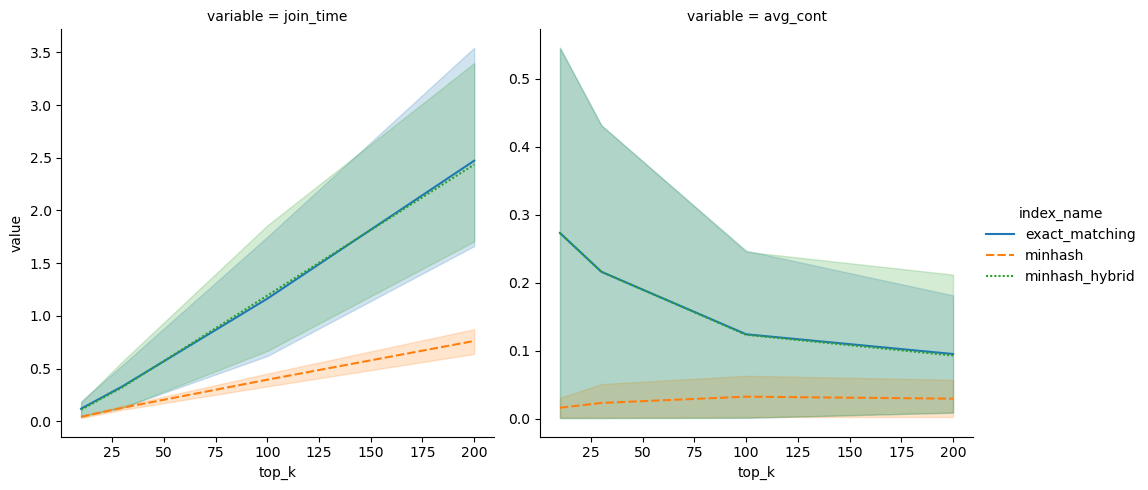

In [58]:
sns.relplot(data=ddf, x="top_k", y="value", hue="index_name", col="variable", kind="line", facet_kws={"sharey":False}, style='index_name')

In [22]:
%%timeit
test_joining(yadl_version, "minhash", f"movies-yadl-depleted", query_column, 30)

0.20 - 0.00
0.15 - 0.00
0.15 - 0.00
0.15 - 0.00
0.15 - 0.00
0.15 - 0.00
0.15 - 0.00
0.15 - 0.00
482 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
test_joining(yadl_version, "minhash_hybrid", f"movies-yadl-depleted", query_column, 30)

0.20 - 0.00
0.17 - 0.00
0.15 - 0.00
0.17 - 0.00
0.20 - 0.00
0.15 - 0.00
0.19 - 0.00
0.19 - 0.00
459 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
test_joining(yadl_version, "exact_matching", f"movies-yadl-depleted", query_column, 30)

0.23 - 0.00
0.24 - 0.00
0.23 - 0.00
0.24 - 0.00
0.20 - 0.00
0.25 - 0.00
0.24 - 0.00
0.22 - 0.00
928 ms ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%%timeit
query_result = load_query_result(yadl_version, "exact_matching", f"us_elections-yadl-depleted", query_column, top_k)
query_result.select_top_k(30)
total_time = 0
for c_id, cand in query_result.candidates.items():
    src_md, cnd_md, left_on, right_on = cand.get_join_information()
    cand_table = pl.read_parquet(cnd_md["full_path"])
    cont = measure_containment(base_table, left_on, cand_table, right_on)
    start_time = datetime.datetime.now()
    merge = base_table.join(cand_table, left_on=left_on, right_on=right_on, how="left")
    end_time = datetime.datetime.now()
    time_required = (end_time - start_time).total_seconds()
    total_time += time_required
    cont.append(cont)
print(total_time)

0.06976900000000001
0.067399
0.06780399999999999
0.067879
0.06902699999999999
0.069468
0.068806
0.06848999999999998
215 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%%timeit
query_result = load_query_result(yadl_version, "minhash", f"us_elections-yadl-depleted", query_column, top_k)
query_result.select_top_k(30)
total_time = 0
cont = []
for c_id, cand in query_result.candidates.items():
    src_md, cnd_md, left_on, right_on = cand.get_join_information()
    cand_table = pl.read_parquet(cnd_md["full_path"])
    cont = measure_containment(base_table, left_on, cand_table, right_on)
    start_time = datetime.datetime.now()
    merge = base_table.join(cand_table, left_on=left_on, right_on=right_on, how="left")
    end_time = datetime.datetime.now()
    time_required = (end_time - start_time).total_seconds()
    total_time += time_required
    cont.append(cont)
print(total_time)

0.13602499999999998
0.13674999999999998
0.13702399999999998
0.128109
0.14404200000000003
0.124614
0.14746499999999998
0.12839499999999998
601 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
